<a href="https://colab.research.google.com/github/omidshz100/AIFA_drug_data_manager/blob/main/NMF_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import pandas as pd
import numpy as np
import warnings
%matplotlib inline
# warnings.filterwarnings('ignore')

#ratings
ratings_df = pd.read_csv('/content/drive/MyDrive/Roberta/nmf/ratings.csv')
ratings_df.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [62]:

n_users = len(ratings_df['userId'].unique())
n_items = len(ratings_df['movieId'].unique())
R_shape = (n_users, n_items)
print(str(n_users) + ' users')
print(str(n_items) + ' items')

610 users
9724 items


In [63]:
ratings_df['rating'].describe()

,rating
count,100836.000000
mean,3.501557
std,1.042529
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


(array([ 1370.,     0.,     0.,     0.,     0.,  2811.,     0.,     0.,
            0.,     0.,  1791.,     0.,     0.,     0.,     0.,  7551.,
            0.,     0.,     0.,     0.,  5550.,     0.,     0.,     0.,
            0., 20047.,     0.,     0.,     0.,     0., 13136.,     0.,
            0.,     0.,     0., 26818.,     0.,     0.,     0.,     0.,
         8551.,     0.,     0.,     0.,     0., 13211.,     0.,     0.,
            0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
        1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
        3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
        4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4]),
 <BarContainer object of 49 artists>)

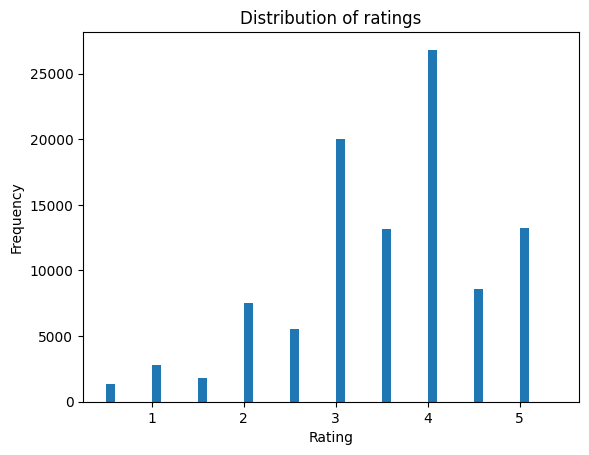

In [64]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings')

# Plot histogram
binwidth = 0.1
data = ratings_df['rating']
plt.hist(data, bins=np.arange(min(data), max(data) + 0.5, binwidth))
# plt.hist(ratings_df['rating'], color='purple', rwidth=0.85)
# plt.show()

In [65]:
ratings_df.rating.value_counts()

,count
rating,
4.0,26818
3.0,20047
5.0,13211
3.5,13136
4.5,8551
2.0,7551
2.5,5550
1.0,2811
1.5,1791


In [66]:

ratings_df.rating.describe()

,rating
count,100836.000000
mean,3.501557
std,1.042529
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


Text(0.5, 1.0, 'Box plot')

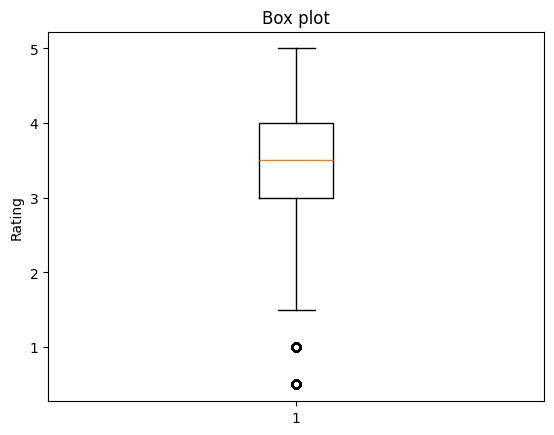

In [67]:

x = ratings_df['rating']

# Create the boxplot
fig1, ax1 = plt.subplots()
ax1.boxplot(x)
plt.ylabel('Rating')
plt.title('Box plot')

Text(0.5, 1.0, 'Distribution of ratings count per user')

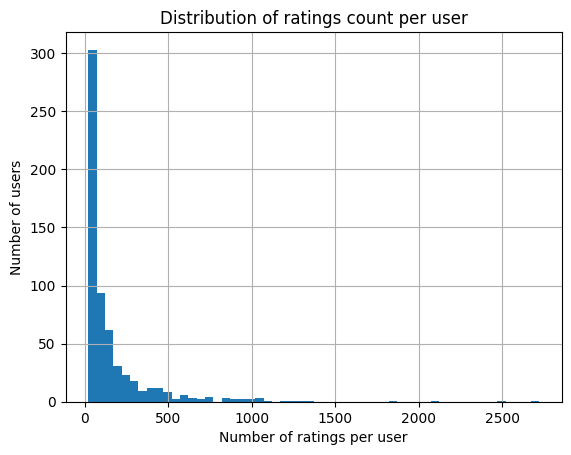

In [68]:
#average number of ppl rated the movies

# count number of ratings per user
users = ratings_df.groupby('userId')['movieId'].nunique()

binwidth = 50
users.hist(bins=np.arange(min(users), max(users) + binwidth, binwidth))
plt.xlabel('Number of ratings per user')
plt.ylabel('Number of users')
plt.title('Distribution of ratings count per user')

In [69]:

#movie titles
movie_titles = pd.read_csv('/content/drive/MyDrive/Roberta/nmf/movies.csv')
movie_titles.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [70]:

movie_titles.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [71]:

df = pd.merge(ratings_df, movie_titles, on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [72]:
#split df to test and train
msk = np.random.rand(len(df)) < 0.8
# train = df[msk]
test = df[~msk]

In [73]:
# train set
#-when we split whole data to train/test there mght be some items (users or movies) that appear just in test set,
# therefor would be no row or column for them on user-movie matrix
# to solve this we initialize train set with the whole data and rows which belong to test set, their movie rating will be replaced with nan (zero)
train = df.copy()
for index, row in test.iterrows():
  uid = row["userId"]
  mid = row["movieId"]

  indx = train.index[(train['userId'] == uid) & (train['movieId'] == mid)][0]
  train.iloc[indx, train.columns.get_loc('rating')] = 0 #np.nan

print(df.shape)
print("train: ", train.shape)
print("test: ", test.shape)


(100836, 6)
train:  (100836, 6)
test:  (20093, 6)


In [74]:

#make user-movie matrix out of train dataset
movie_matrix = train.pivot_table(index='userId', columns='movieId', values='rating') #use Train
movie_matrix.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
colid2movieId = dict(zip(range(len(movie_matrix.columns)), list(movie_matrix.columns)))
rowid2userId = dict(zip(range(len(movie_matrix.index)), list(movie_matrix.index)))

movieId2colid = {v: k for k, v in colid2movieId.items()}
userId2rowid = {v: k for k, v in rowid2userId.items()}

In [76]:
#convert dataframe to list
movie_matrix = movie_matrix.values.tolist()
R = np.asarray(movie_matrix)
R[0]
R.shape

(610, 9724)

In [77]:
# replace nans to zero
R = np.nan_to_num(R)
R[0]

array([4., 0., 4., ..., 0., 0., 0.])

In [78]:
# Computing the sparsity of R
print(len(R.nonzero()[0]) / float(R.shape[0] * R.shape[1]))
# Sparsity is 1.3%. This means that 1.3% of the user-item ratings have a value.


0.013612255632506357


In [79]:
from sklearn.decomposition import NMF


nmf_model = NMF(n_components=100)     # starts with 20 latents factors

# Matrix factorization               # V ~ W.H  (Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. )
nmf_model.fit(R)                     # R can be array-like or sparse, here it is array-like (dense)
P = nmf_model.transform(R)       # user latent factors (= W, called the features matrix)
Q = nmf_model.components_.T          # item latent factors (= H.T) (H is called the coefficient matrix)


R_pred = P.dot(Q.T)


print("R: ", R.shape)
print('User features - P:', P.shape)
print('Item features - Q:', Q.shape)
print('Predicted R:', R_pred.shape)
print()
print('R ~ P * Q.T:')
print(R_pred.round(2))

R:  (610, 9724)
User features - P: (610, 100)
Item features - Q: (9724, 100)
Predicted R: (610, 9724)

R ~ P * Q.T:
[[3.73 0.   4.06 ... 0.   0.   0.  ]
 [0.13 0.11 0.   ... 0.01 0.01 0.02]
 [0.13 0.03 0.07 ... 0.   0.   0.  ]
 ...
 [1.94 2.05 1.88 ... 0.   0.   0.02]
 [0.51 0.45 0.15 ... 0.   0.   0.  ]
 [0.05 0.   0.   ... 0.   0.   0.01]]


In [80]:

#predict ratings for test set


def pred_rating(row):
  uid = row["userId"]
  rowid = userId2rowid[uid]
  mid = row["movieId"]
  colid = movieId2colid[mid]

  return R_pred[rowid][colid]

test['pred_rating'] = test.apply (lambda row: pred_rating(row), axis=1)

test.head()


/tmp/ipython-input-80-990360720.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_rating'] = test.apply (lambda row: pred_rating(row), axis=1)


,userId,movieId,rating,timestamp,title,genres,pred_rating
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller,0.000000
12,1,223,3.0,964980985,Clerks (1994),Comedy,0.000000
14,1,235,4.0,964980908,Ed Wood (1994),Comedy|Drama,0.000000
18,1,333,5.0,964981179,Tommy Boy (1995),Comedy,0.000000
19,1,349,4.0,964982563,Clear and Present Danger (1994),Action|Crime|Drama|Thriller,0.119254


In [81]:
#compute RMSE

y_predicted = test['pred_rating']
y_actual = test['rating']

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_actual, y_predicted))
print(rms)

3.339759613379339
